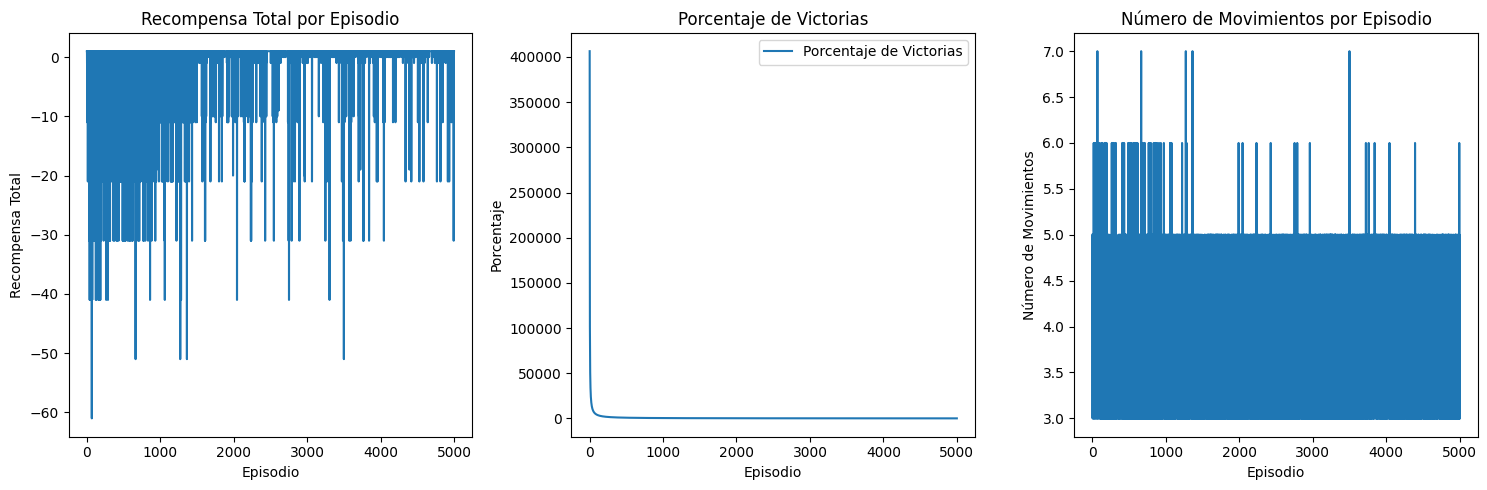

Entrenamiento completado.
Victorias: 4064
Derrotas: 704
Empates: 232


In [2]:
import numpy as np
import random
import matplotlib.pyplot as plt

# Definición del entorno de Tres en Línea
class TicTacToeEnv:
    def __init__(self):
        self.reset()

    def reset(self):
        self.board = np.zeros((3, 3))  # 0 representa un espacio vacío, 1 representa 'X', -1 representa 'O'
        self.done = False
        self.winner = None
        return self.board.flatten()

    def check_winner(self):
        # Comprobar filas, columnas y diagonales
        lines = [self.board[i, :] for i in range(3)] + [self.board[:, i] for i in range(3)] + [np.diag(self.board)] + [np.diag(np.fliplr(self.board))]
        for line in lines:
            if np.all(line == 1):
                return 1  # 'X' gana
            elif np.all(line == -1):
                return -1  # 'O' gana
        if not np.any(self.board == 0):
            return 0  # Empate
        return None

    def step(self, action, player):
        x, y = divmod(action, 3)
        if self.board[x, y] != 0 or self.done:
            return self.board.flatten(), -10, self.done  # Penalizar por jugada inválida

        self.board[x, y] = player
        self.winner = self.check_winner()
        if self.winner is not None:
            self.done = True
            reward = 1 if self.winner == 1 else -1 if self.winner == -1 else 0
        else:
            reward = 0

        return self.board.flatten(), reward, self.done

    def get_valid_actions(self):
        return [i for i in range(9) if self.board.flatten()[i] == 0]

# Clase de Q-learning
class QLearningAgent:
    def __init__(self, learning_rate=0.1, discount_rate=0.9, epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.01):
        self.q_table = np.zeros((3**9, 9))  # Tabla Q para todos los estados posibles
        self.learning_rate = learning_rate
        self.discount_rate = discount_rate
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.action_size = 9
        self.rewards = []
        self.win_count = 0
        self.loss_count = 0
        self.draw_count = 0
        self.moves = []  # Añadido para registrar el número de movimientos por episodio

    def get_state_index(self, state):
        state = state.copy()
        state[state == -1] = 2
        state[state == 0] = 0
        state[state == 1] = 1
        state_str = ''.join(map(str, state.astype(int)))
        return int(state_str, 3)

    def choose_action(self, state):
        if np.random.uniform(0, 1) < self.epsilon:
            return random.choice(env.get_valid_actions())  # Exploración
        state_index = self.get_state_index(state)
        return np.argmax(self.q_table[state_index])  # Explotación

    def learn(self, state, action, reward, next_state):
        state_index = self.get_state_index(state)
        next_state_index = self.get_state_index(next_state)
        best_next_action = np.argmax(self.q_table[next_state_index])
        td_target = reward + self.discount_rate * self.q_table[next_state_index][best_next_action]
        td_error = td_target - self.q_table[state_index][action]
        self.q_table[state_index][action] += self.learning_rate * td_error

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

# Inicialización del entorno y el agente
env = TicTacToeEnv()
agent = QLearningAgent()

# Entrenamiento del agente
episodes = 5000
for episode in range(episodes):
    state = env.reset()
    done = False
    total_reward = 0
    moves = 0

    while not done:
        action = agent.choose_action(state)
        next_state, reward, done = env.step(action, 1)  # Agente 'X'
        moves += 1
        if not done:
            opponent_action = random.choice(env.get_valid_actions())  # Oponente aleatorio
            next_state, opponent_reward, done = env.step(opponent_action, -1)  # Oponente 'O'
            reward += opponent_reward

        agent.learn(state, action, reward, next_state)
        state = next_state
        total_reward += reward

    # Guardar estadísticas
    agent.rewards.append(total_reward)
    if total_reward > 0:
        agent.win_count += 1
    elif total_reward < 0:
        agent.loss_count += 1
    else:
        agent.draw_count += 1

    # Guardar el número de movimientos por episodio
    agent.moves.append(moves)

# Graficar métricas
plt.figure(figsize=(15, 5))

# Gráfico de recompensa total por episodio
plt.subplot(1, 3, 1)
plt.plot(agent.rewards)
plt.xlabel('Episodio')
plt.ylabel('Recompensa Total')
plt.title('Recompensa Total por Episodio')

# Gráfico de porcentaje de victorias
plt.subplot(1, 3, 2)
total_games = np.arange(1, episodes + 1)
win_percentage = [agent.win_count / episode * 100 for episode in total_games]
plt.plot(total_games, win_percentage, label='Porcentaje de Victorias')
plt.xlabel('Episodio')
plt.ylabel('Porcentaje')
plt.title('Porcentaje de Victorias')
plt.legend()

# Gráfico de movimientos por episodio
plt.subplot(1, 3, 3)
plt.plot(agent.moves)
plt.xlabel('Episodio')
plt.ylabel('Número de Movimientos')
plt.title('Número de Movimientos por Episodio')

plt.tight_layout()
plt.show()

print(f"Entrenamiento completado.\nVictorias: {agent.win_count}\nDerrotas: {agent.loss_count}\nEmpates: {agent.draw_count}")